In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('/Users/vsriniv/Documents/Research/Github/PatchSim')
import patchsim as sim

In [2]:
gt = pd.read_csv('../data/Ebola_Updated_Feb03.csv',delimiter='\t',dtype={'date':str})
gt['Date'] = gt.date.apply(lambda x: datetime.strptime(x,'%Y%m%d'))
gt = gt[gt.Date>=datetime.strptime('20180805','%Y%m%d')] ## Starting on August 5th, the first non-NaN value
gt['Ob_Day'] = gt.Date.apply(lambda x : (x - datetime.strptime('20180805','%Y%m%d')).days)
gt['Ob_Week'] = gt.Ob_Day.apply(lambda x: x//7)

In [3]:
# Get top 6 healthzones
key_hzs = gt[gt.Date==gt.Date.max()][['health_zone','total_c']].sort_values('total_c',ascending=False).head(7)['health_zone'].values
key_hzs = sorted(list(set(key_hzs) - {'all'}))

(17748, 17930)

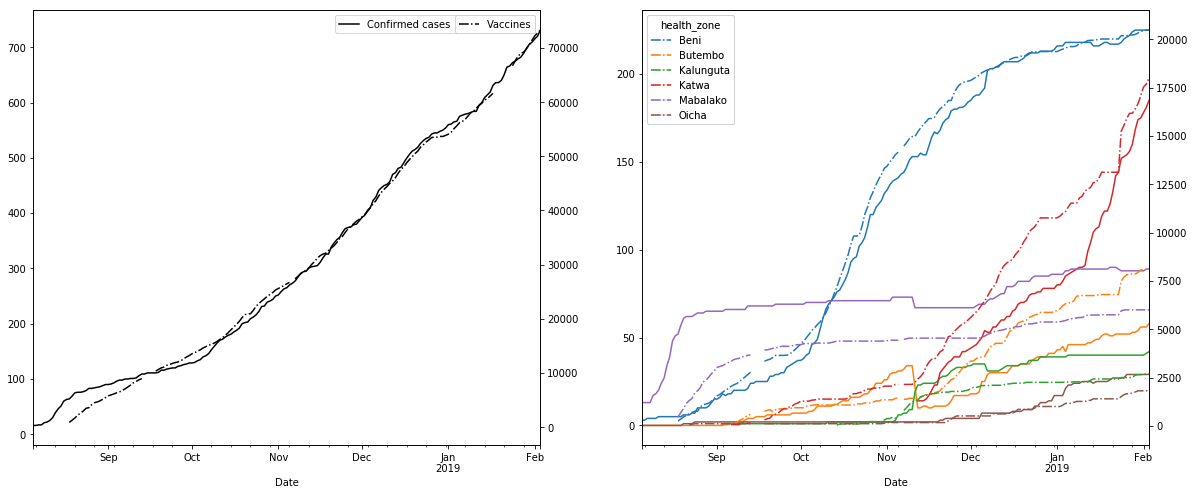

In [5]:
f, axarr = plt.subplots(1,2, figsize=(20,8))

gt[gt.health_zone=='all'].plot(x='Date',y='total_c',ax=axarr[0],color='k',label='Confirmed cases                          ')
ax0 = axarr[0].twinx()
gt[gt.health_zone=='all'].plot(x='Date',y='total_vacc',ax=ax0, color='k', label='Vaccines', ls='-.')

gt[gt.health_zone.isin(key_hzs)].pivot(index='Date',columns='health_zone',values='total_c').plot(ax=axarr[1])
ax1 = axarr[1].twinx()
gt[gt.health_zone.isin(key_hzs)].pivot(index='Date',columns='health_zone',values='total_vacc').plot(ax=ax1, ls='-.')
    
gt_start = datetime.strptime('20180805','%Y%m%d')
gt_end = datetime.strptime('20190203','%Y%m%d')
axarr[0].set_xlim([gt_start,gt_end])
axarr[1].set_xlim([gt_start,gt_end])

### Use below snippet if you need weekly ground truth (and plots)

In [6]:
# gt_wk = gt.drop_duplicates(['health_zone','Ob_Week'],keep='first')

# f, axarr = plt.subplots(1,2, figsize=(24,8))

# gt_wk[gt_wk.health_zone=='all'].plot(x='Ob_Week',y='total_c',ax=axarr[0],color='k',label='Confirmed cases                          ')
# ax0 = axarr[0].twinx()
# gt_wk[gt_wk.health_zone=='all'].plot(x='Ob_Week',y='total_vacc',ax=ax0, color='k', label='Vaccines', ls='-.')


# gt_wk[gt_wk.health_zone.isin(key_hzs)].pivot(index='Ob_Week',columns='health_zone',values='total_c').plot(ax=axarr[1])
# ax1 = axarr[1].twinx()
# gt_wk[gt_wk.health_zone.isin(key_hzs)].pivot(index='Ob_Week',columns='health_zone',values='total_vacc').plot(ax=ax1,ls='-.')

### Analyzing vax_to_cases ratio

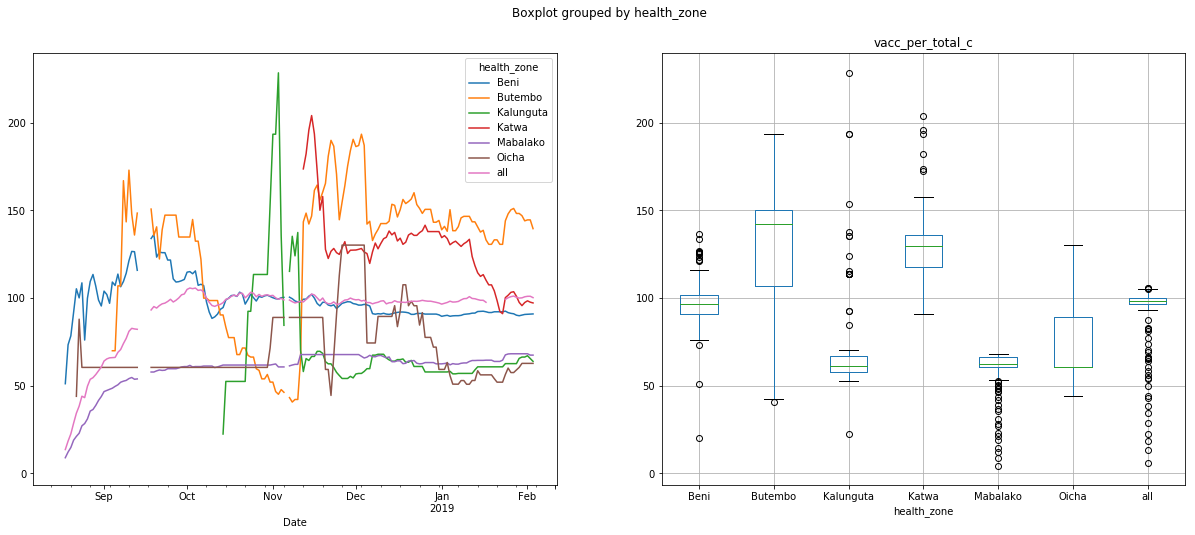

In [7]:
with np.errstate(divide='ignore'):
    gt['vacc_per_total_c'] = np.divide(gt.total_vacc.values,gt.total_c.values)
f,axarr = plt.subplots(1,2,figsize=(20,8))
gt[gt.health_zone.isin(key_hzs+['all'])].pivot(index='Date',columns='health_zone',values='vacc_per_total_c').plot(ax=axarr[0])
gt[gt.health_zone.isin(key_hzs+['all'])].boxplot(column='vacc_per_total_c',by='health_zone',ax=axarr[1])

### Preparing seeding file (Parameters: seed_thresh, seed_N)

In [8]:
seed_thresh = 5 ## Threshold of cases to cross for seeding
seed_N = 3 ## Number of distinct health zones to seed in

seed_df = gt[(gt.total_c>=seed_thresh)&(gt.health_zone.isin(key_hzs))].drop_duplicates('health_zone',keep='first')[['Ob_Day','health_zone','total_c']]
seed_df['health_zone'] = seed_df.health_zone.str.upper()
seed_df['total_c'] = seed_df.total_c.astype(int)
seed_df.sort_values('Ob_Day').head(seed_N).to_csv('../data/patchsim/seed_schedule.txt',index=None,header=None,sep=' ')

### Preparing vaccine file (Parameters: ct_eff, ct_scaler)

In [104]:
ct_efficacy = 1.0 ## 
ct_scaler = 20 ## If perfect contact tracing, x times the number of mentioned vaccines are doled out (correcting for metapopulation approximation)

vax_df = pd.DataFrame()
for k in key_hzs:
    T = len(gt[gt.health_zone=='all'])
    days = range(T)
    hz = np.repeat(k.upper(),T)
    vaxs = gt[gt.health_zone==k]['total_vacc'].diff().fillna(0)*int(ct_scaler*ct_efficacy)
    vax_df = vax_df.append(pd.DataFrame({'Day':days,'health_zone':hz,'Vacc':vaxs}))   
#vax_df.pivot(index='Day',columns='health_zone',values='Vacc').plot()
vax_df.to_csv('../data/patchsim/vax_schedule.txt',index=None,header=None,sep=' ')

### Editing base config file (Parameters: base_beta, alpha, gamma)

In [188]:
base_beta = 0.185
alpha = 0.133
gamma = 0.1

base_cfg = sim.read_config('../data/patchsim/base_cfg.txt')

base_cfg['ExposureRate'] = beta
base_cfg['InfectionRate'] = alpha
base_cfg['RecoveryRate'] = gamma
base_cfg['Duration'] = T

random=False
if random:
    base_cfg['RandomSeed'] = 12345

### Editing param_file (Parameters: beta_scalers)

In [189]:
beta_scalers = np.array([1.6,0.4,0.3,1.1,0.9,0])
param_dict = {'id':['BENI','BUTEMBO','KALUNGUTA','KATWA','MABALAKO','OICHA'], 'beta':np.repeat(base_beta,6),'alpha':np.repeat(alpha,6),'gamma':np.repeat(gamma,6), 'beta_scaling':beta_scalers}
param_df = pd.DataFrame.from_dict(param_dict)
param_df['beta'] = param_df.beta*param_df.beta_scaling
param_df.drop('beta_scaling',axis=1,inplace=True)
param_df.to_csv('../data/patchsim/param_file.txt',sep=' ',index=None)

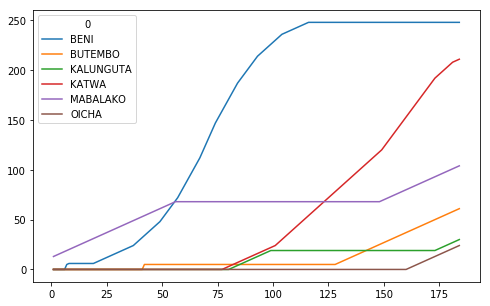

In [190]:
sim.run_disease_simulation(base_cfg,write_epi=True)
out_df = pd.read_csv('../outputs/sample0.out',index_col=0,delim_whitespace=True,header=None).cumsum(axis=1)
out_df.loc[[k.upper() for k in key_hzs]].T.plot(figsize=(8,5))

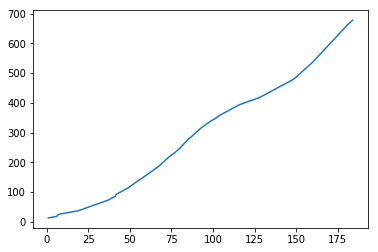

In [191]:
out_df.loc[[k.upper() for k in key_hzs]].sum().plot()

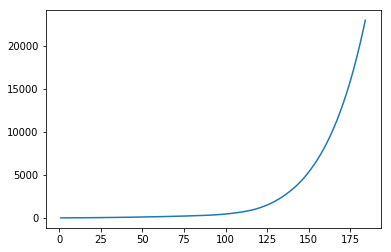

In [192]:
out_df.sum().plot()